<a href="https://colab.research.google.com/github/MitchellPritchett/pdse_ai_workshop/blob/main/%5BPDSE%5DAI_workshop_week9(dim_red).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9주차 차원 축소
많은 경우에 특성이 너무 많은 데이터를 접하게 됩니다. 수천 개에서 수백만 개의 특성을 가지는 데이터도 많죠.  
특성이 너무 많으면 훈련이 느려지고, 좋은 솔루션을 찾기 어려울 수 있습니다.  
이런 문제를 차원의 저주(curse of dimensionality)라고 합니다.

특성 수를 크게 줄여서 문제를 풀 수 있는 경우가 있습니다. 또 특성이 많은 데이터를 차원 축소를 통해서 보기 좋게 시각화할 수도 있습니다.  
하지만 머신 러닝에서 차원을 축소시키면 일부 정보가 유실되기 때문에 훈련 속도는 빨라지더라도 일반적으로 시스템의 성능은 떨어지게 됩니다.  
따라서 먼저 원본으로 훈련을 시켜보고 시간이 너무 오래 걸리는지 확인을 해보고 그럴 경우에 차원을 축소하는 것이 좋습니다.  
어떤 경우에는 노이즈를 제거하고 불필요한 세부사항을 걸러내서 더 좋은 성능을 보일 수도 있지만 일반적으로는 훈련 속도만 빨라집니다.  

차원 축소에는 두 가지 접근법이 있는데, 투영과 매니폴드 학습이 있습니다. (구체적인 내용은 여기서 언급하지 않겠습니다)
그리고 이들을 기반으로 구체적인 차원 축소 알고리즘들이 있습니다. 대표적으로 PCA, 커널 PCA, 그리고 LLE가 있습니다.  
이 튜토리얼에서는 테크니컬하게 sklearn에서 차원 축소 알고리즘을 사용할 수 있는 코드 사용법을 다루겠습니다.

## 설정

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## PCA

In [ ]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [ ]:
X3D_inv = pca.inverse_transform(X2D)

In [ ]:
np.allclose(X3D_inv, X)

False

In [ ]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01017033779284855

In [ ]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### Explained Variance Ratio

In [ ]:
pca.explained_variance_ratio_

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [ ]:
1 - pca.explained_variance_ratio_.sum()

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [ ]:
np.square(s) / np.square(s).sum()

### Choosing the Right Number of Dimensions

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
d

154

Saving figure explained_variance_plot


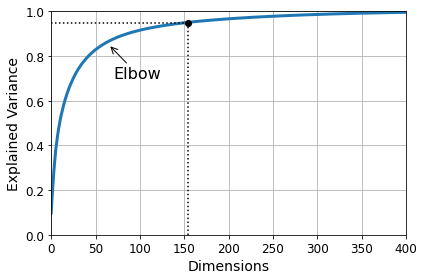

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

### PCA for Compression

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
X_reduced_pca = X_reduced

### Randomized PCA

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [ ]:
X_reduced_inc_pca = X_reduced

## Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


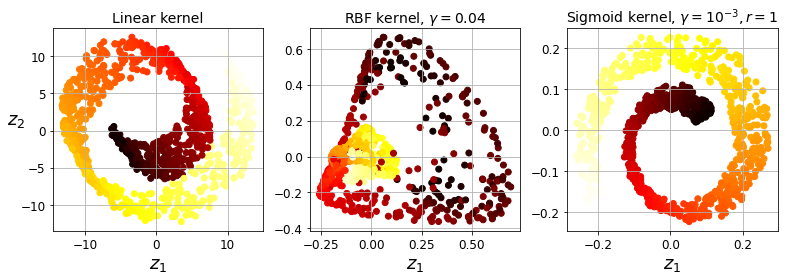

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

### Selecting a Kernel and Tuning Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [ ]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

1.4326103121600706e-26

## LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

## Other Dimensionality Reduction Techniques

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)